# Hyperparameter tuning by grid-search

No notebook anterior, vimos que os hiperparâmetros podem afetar o
desempenho estatístico de um modelo. Neste caderno, mostraremos como
otimizar hiperparâmetros usando uma abordagem de pesquisa em grade.

## Nosso modelo preditivo

Vamos recarregar o conjunto de dados como fizemos anteriormente:

In [1]:
from sklearn import set_config

set_config(display="diagram")

In [44]:
import pandas as pd

adult_census = pd.read_csv("adult-census.csv")
# drop the duplicated column `"education-num"` as stated in the first notebook
adult_census = adult_census.drop(columns=['ID','fnlwgt:','education-num:'])

Extraímos a coluna que contém o destino.

In [45]:
target_name = "class"
target = adult_census[target_name]
target

0        <=50K
1        <=50K
2        <=50K
3        <=50K
4        <=50K
         ...  
32556    <=50K
32557     >50K
32558    <=50K
32559    <=50K
32560     >50K
Name: class, Length: 32561, dtype: object

Tiramos de nossos dados o alvo e a coluna `" education-num "` que
duplica a informação da coluna `" educação "`.

In [54]:
data = adult_census.drop(columns=[target_name])
#data['occupation:'] = data['occupation:'].map({'Handlers-cleaners' : '?'})
data['native-country:'] = data['native-country:'].replace(['Holand-Netherlands'], 'United-States')
data.head(5) 

,age,workclass,education:,marital-status:,occupation:,relationship:,race:,sex:,capital-gain:,capital-loss:,hours-per-week:,native-country:
0,39,State-gov,Bachelors,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States
1,50,Self-emp-not-inc,Bachelors,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States
2,38,Private,HS-grad,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States
3,53,Private,11th,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States
4,28,Private,Bachelors,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba


Depois que o conjunto de dados é carregado, nós o dividimos em conjuntos de treinamento e teste.

In [47]:
from sklearn.model_selection import train_test_split

data_train, data_test, target_train, target_test = train_test_split(
    data, target, random_state=42)

Vamos definir um pipeline como visto no primeiro módulo. Ele vai lidar com ambos
características numéricas e categóricas.

Como usaremos um modelo baseado em árvore como um preditor, aqui aplicamos um ordinal
codificador nas características categóricas: ele codifica todas as categorias com um
inteiro arbitrário. Para modelos simples, como modelos lineares, um codificador one-hot
deve ser preferido. Mas para modelos complexos, em particular modelos baseados em árvore,
o codificador ordinal é útil, pois evita ter alta dimensão
representações.

Primeiro, selecionamos todas as colunas categóricas.

In [49]:
from sklearn.compose import make_column_selector as selector

categorical_columns_selector = selector(dtype_include=object)
categorical_columns = categorical_columns_selector(data)

Em seguida, construímos nosso codificador ordinal, fornecendo a ele as categorias conhecidas.

In [50]:
from sklearn.preprocessing import OrdinalEncoder

categorical_preprocessor = OrdinalEncoder()

Agora usamos um transformador de coluna com código para selecionar as colunas categóricas
e aplique a eles o codificador ordinal.

In [51]:
from sklearn.compose import ColumnTransformer

preprocessor = ColumnTransformer([
    ('cat-preprocessor', categorical_preprocessor, categorical_columns)],
    remainder='passthrough', sparse_threshold=0)

Finalmente, usamos um classificador baseado em árvore (ou seja, aumento de gradiente de histograma) para
prever se uma pessoa ganha ou não mais de 50 mil $ por ano.

In [52]:
# for the moment this line is required to import HistGradientBoostingClassifier
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.pipeline import Pipeline

model = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier",
     HistGradientBoostingClassifier(random_state=42, max_leaf_nodes=4))])
model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough', sparse_threshold=0,
                                   transformers=[('cat-preprocessor',
                                                  OrdinalEncoder(),
                                                  ['workclass', 'education:',
                                                   'marital-status:',
                                                   'occupation:',
                                                   'relationship:', 'race:',
                                                   'sex:',
                                                   'native-country:'])])),
                ('classifier',
                 HistGradientBoostingClassifier(max_leaf_nodes=4,
                                                random_state=42))])

## Ajuste usando uma pesquisa em grade

Em vez de escrever manualmente os dois loops `for`, o scikit-learn fornece um
classe chamada `GridSearchCV` que implementa a busca exaustiva implementada
durante o exercício.

Vamos ver como usar o estimador `GridSearchCV` para fazer tal pesquisa.
Uma vez que a pesquisa em grade será cara, exploraremos apenas a combinação
taxa de aprendizagem e o número máximo de nós.

In [53]:
%%time
from sklearn.model_selection import GridSearchCV

param_grid = {
    'classifier__learning_rate': (0.05, 0.1, 0.5, 1, 5),
    'classifier__max_leaf_nodes': (3, 10, 30, 100)}
model_grid_search = GridSearchCV(model, param_grid=param_grid,
                                 n_jobs=4, cv=2)
model_grid_search.fit(data_train, target_train)

Wall time: 8.76 s


GridSearchCV(cv=2,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          sparse_threshold=0,
                                                          transformers=[('cat-preprocessor',
                                                                         OrdinalEncoder(),
                                                                         ['workclass',
                                                                          'education:',
                                                                          'marital-status:',
                                                                          'occupation:',
                                                                          'relationship:',
                                                                          'race:',
                                                                          'sex:',
                                                                          'native-country:'])])),
                                       ('classifier',
                                        HistGradientBoostingClassifier(max_leaf_nodes=4,
                                                                       random_state=42))]),
             n_jobs=4,
             param_grid={'classifier__learning_rate': (0.05, 0.1, 0.5, 1, 5),
                         'classifier__max_leaf_nodes': (3, 10, 30, 100)})

Finalmente, vamos verificar a precisão do nosso modelo usando o conjunto de teste.

In [55]:
accuracy = model_grid_search.score(data_test, target_test)
print(
    f"The test accuracy score of the grid-searched pipeline is: "
    f"{accuracy:.2f}")

The test accuracy score of the grid-searched pipeline is: 0.88


<div class="admonition warning alert alert-danger">
<p class="first admonition-title" style="font-weight: bold;">Warning</p>
<p>Esteja ciente de que a avaliação normalmente deve ser realizada em um
estrutura de validação cruzada, fornecendo <tt class="docutils literal">model_grid_search</tt> como um modelo para
a<tt class="docutils literal">cross_validate</tt> function.</p>
<p class="last">Aqui, estamos usando uma única divisão de teste de trem para destacar as especificidades
do<tt class="docutils literal">model_grid_search</tt> instância. Mostraremos tais exemplos no último
seção deste notebook.</p>
</div>

O estimador `GridSearchCV` leva um parâmetro` param_grid` que define
todos os hiperparâmetros e seus valores associados. A pesquisa em grade estará em
encarregado de criar todas as combinações possíveis e testá-las.

O número de combinações será igual ao produto do
número de valores a serem explorados para cada parâmetro (por exemplo, em nosso exemplo 4 x 4
combinações). Assim, adicionar novos parâmetros com seus valores associados para ser
explorados tornam-se rapidamente caros do ponto de vista computacional.

Uma vez que a pesquisa de grade é ajustada, ela pode ser usada como qualquer outro preditor por
chamando `Predict` e` Predict_proba`. Internamente, ele usará o modelo com
os melhores parâmetros encontrados durante o `fit`.

Obtenha previsões para as 5 primeiras amostras usando o estimador com o melhor
parâmetros.

In [56]:
model_grid_search.predict(data_test.iloc[0:5])

array(['<=50K', '<=50K', '>50K', '<=50K', '<=50K'], dtype=object)

Você pode saber sobre esses parâmetros observando os `best_params_`
atributo.

In [57]:
print(f"The best set of parameters is: "
      f"{model_grid_search.best_params_}")

The best set of parameters is: {'classifier__learning_rate': 0.05, 'classifier__max_leaf_nodes': 30}


A precisão e os melhores parâmetros do pipeline pesquisado na grade são
semelhantes aos que encontramos no exercício anterior, onde pesquisamos o
melhores parâmetros "à mão" por meio de um loop for duplo.

Além disso, podemos inspecionar todos os resultados armazenados no atributo
`cv_results_` da grade de pesquisa. Vamos filtrar algumas colunas específicas
a partir desses resultados.

In [58]:
cv_results = pd.DataFrame(model_grid_search.cv_results_).sort_values(
    "mean_test_score", ascending=False)
cv_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__learning_rate,param_classifier__max_leaf_nodes,params,split0_test_score,split1_test_score,mean_test_score,std_test_score,rank_test_score
2,0.800390,0.002332,0.114573,0.003860,0.05,30,"{'classifier__learning_rate': 0.05, 'classifie...",0.865520,0.870352,0.867936,0.002416,1
6,0.628320,0.051861,0.101728,0.006982,0.1,30,"{'classifier__learning_rate': 0.1, 'classifier...",0.864947,0.869943,0.867445,0.002498,2
5,0.395767,0.001157,0.093896,0.000146,0.1,10,"{'classifier__learning_rate': 0.1, 'classifier...",0.863636,0.869206,0.866421,0.002785,3
9,0.156732,0.002043,0.063990,0.003189,0.5,10,"{'classifier__learning_rate': 0.5, 'classifier...",0.863636,0.868223,0.865930,0.002293,4
3,2.276268,0.022425,0.144378,0.005481,0.05,100,"{'classifier__learning_rate': 0.05, 'classifie...",0.860688,0.868960,0.864824,0.004136,5


Vamos nos concentrar nas colunas mais interessantes e encurtar o parâmetro
nomes para remover o prefixo `" param_classifier __ "` para facilitar a leitura:

In [59]:
# get the parameter names
column_results = [f"param_{name}" for name in param_grid.keys()]
column_results += [
    "mean_test_score", "std_test_score", "rank_test_score"]
cv_results = cv_results[column_results]

In [60]:
def shorten_param(param_name):
    if "__" in param_name:
        return param_name.rsplit("__", 1)[1]
    return param_name


cv_results = cv_results.rename(shorten_param, axis=1)
cv_results

,learning_rate,max_leaf_nodes,mean_test_score,std_test_score,rank_test_score
2,0.05,30,0.867936,0.002416,1
6,0.1,30,0.867445,0.002498,2
5,0.1,10,0.866421,0.002785,3
9,0.5,10,0.865930,0.002293,4
3,0.05,100,0.864824,0.004136,5
10,0.5,30,0.864742,0.002088,6
7,0.1,100,0.864333,0.004382,7
8,0.5,3,0.864333,0.003071,7
12,1,3,0.860893,0.001597,9
1,0.05,10,0.860729,0.002498,10


Com apenas 2 parâmetros, podemos querer visualizar a pesquisa em grade como um
mapa de calor. Precisamos transformar nosso `cv_results` em um dataframe onde:

- as linhas corresponderão aos valores da taxa de aprendizagem;
- as colunas corresponderão ao número máximo de folhas;
- o conteúdo do quadro de dados será a pontuação média dos testes.

In [61]:
pivoted_cv_results = cv_results.pivot_table(
    values="mean_test_score", index=["learning_rate"],
    columns=["max_leaf_nodes"])

pivoted_cv_results

max_leaf_nodes,3,10,30,100
learning_rate,,,,
0.05,0.832637,0.860729,0.867936,0.864824
0.10,0.853522,0.866421,0.867445,0.864333
0.50,0.864333,0.865930,0.864742,0.855037
1.00,0.860893,0.856921,0.849795,0.835381
5.00,0.283784,0.611753,0.789394,0.590254


Podemos usar uma representação de mapa de calor para mostrar o quadro de dados acima visualmente.

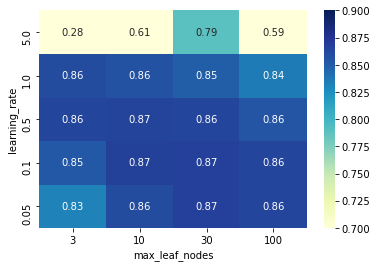

In [62]:
import seaborn as sns

ax = sns.heatmap(pivoted_cv_results, annot=True, cmap="YlGnBu", vmin=0.7,
                 vmax=0.9)
ax.invert_yaxis()

As tabelas acima destacam o seguinte:

* para valores muito altos de `learning_rate`, o desempenho estatístico do
  modelo está degradado e ajustar o valor de `max_leaf_nodes` não pode corrigir
  Esse problema;
* fora desta região patológica, observamos que a escolha ideal
  de `max_leaf_nodes` depende do valor de` learning_rate`;
* em particular, observamos uma "diagonal" de bons modelos com uma precisão
  perto do máximo de 0,87: quando o valor de `max_leaf_nodes` é
  aumentado, deve-se aumentar o valor de `learning_rate` de acordo
  para preservar uma boa precisão.

O significado preciso desses dois parâmetros será explicado em um último
caderno.

Por agora, iremos notar que, em geral, **não existe um parâmetro ideal único
configuração**: 6 modelos da configuração de 16 parâmetros atingem o máximo
precisão (até pequenas flutuações aleatórias causadas pela amostragem do
conjunto de treinamento).

Neste caderno vimos:

* como otimizar os hiperparâmetros de um modelo preditivo por meio de um
  pesquisa em grade;
* que pesquisar mais de dois hiperparâmetros é muito caro;
* que uma busca em grade não necessariamente encontra uma solução ótima.